In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import io_ops
import pathlib
import os
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0

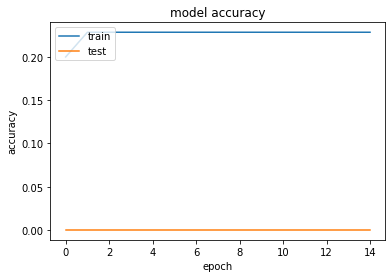

<Figure size 432x288 with 0 Axes>

In [3]:
def get_dataset_filepath_and_label_train_test_split(dir_path, test_size = 0.3):
    audio = os.path.join(dir_path, 'animal_sounds')
    unique_labels = [item for item in os.listdir(audio) if os.path.isdir(os.path.join(audio, item))]
    audio_ds = pathlib.Path(audio)
    list_ds = tf.data.Dataset.list_files(str(audio_ds/'*/*'))
    
    index = 0
    record = {}
    for label in unique_labels:
        record[label] = index
        index += 1        
        
    df = pd.DataFrame(columns = ['file_path', 'label'])
    for f in list_ds.take(50):
        filepath = str(f.numpy())
        label = record[filepath.split('/')[-2]]
        file_name = filepath[1:]
        row = pd.Series([file_name, label], index = ['file_path', 'label'])
        df = df.append(row, ignore_index=True) 
        
    df_train, df_test = train_test_split(df, test_size=test_size)
    
    return df_train, df_test


def load_wav_file(filename):
  """Loads an audio file and returns a float PCM-encoded array of samples.

  Args:
    filename: Path to the .wav file to load.

  Returns:
    Numpy array holding the sample data as floats between -1.0 and 1.0.
  """
  with tf.compat.v1.Session(graph=tf.Graph()) as sess:
    wav_filename_placeholder = tf.compat.v1.placeholder(tf.string, [])
    wav_loader = io_ops.read_file(wav_filename_placeholder)
    wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
    data = sess.run(wav_decoder, feed_dict={wav_filename_placeholder: filename}).audio.flatten()
    
    return data

def get_dataset(df):
    df['feature_ds'] = df['file_path'].apply(lambda x: x[1:-1]).apply(load_wav_file)
    num_of_features = 10000#len(df.head(1).feature_ds.values[0])
    columns = []
    for i in range(num_of_features):
        column = 'feature_ds_' + str(i)
        columns.append(column)
    df_feature = pd.DataFrame(df['feature_ds'].to_list()).loc[:,:9999]
    df_feature.columns=columns[:10000]
    df_feature['label'] = df['label']
    
    df_feature = df_feature.fillna(0.0)
    
    return df_feature

def get_FC_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1)])
    optimizer=keras.optimizers.Adam(learning_rate=100)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        
    return model


def get_CNN_model():
    model = models.Sequential()
    model.add(tf.keras.layers.Reshape((100, 100, 1), input_shape=(10000,)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(100, 100, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.summary()
    optimizer=keras.optimizers.Adam(learning_rate=10000)
    model.compile(optimizer=optimizer,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
        
    return model

def get_RNN_model():
    model = keras.Sequential()
    # Add an Embedding layer expecting input vocab of size 1000, and
    # output embedding dimension of size 64.
    model.add(layers.Embedding(input_dim=10000, output_dim=64))
    # Add a LSTM layer with 128 internal units.
    model.add(layers.LSTM(128))
    # Add a Dense layer with 10 units.
    model.add(layers.Dense(10))
    model.summary()
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="sgd", metrics=["accuracy"])
    
    return model


def learning_curve_plotting(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig('learning_curve.jpg')


def main(option):
    
    dir_path = os.path.dirname(os.path.realpath("__file__"))
    df_train, df_test = get_dataset_filepath_and_label_train_test_split(dir_path)
    ds_train = get_dataset(df_train)
    ds_test = get_dataset(df_test)
    #df_train.to_csv('audio_list_train.csv')
    #df_test.to_csv('audio_list_test.csv')
    target_train = ds_train.pop('label')
    target_test = ds_test.pop('label')
    
    if option == 'RF':
        clf = RandomForestClassifier()
        clf.fit(ds_train, target_train)
        pred_test = clf.predict(ds_test)
        print (accuracy_score(target_test, pred_test))
        
    elif option == 'FC':
        train_dataset = tf.data.Dataset.from_tensor_slices((ds_train.values, target_train.values))
        train_dataset = train_dataset.shuffle(len(ds_train)).batch(1)
        test_dataset = tf.data.Dataset.from_tensor_slices((ds_test.values, target_test.values))
        test_dataset = test_dataset.shuffle(len(ds_test)).batch(1)
        model = get_FC_model()
        history = model.fit(train_dataset, validation_data = test_dataset, epochs=15)
        learning_curve_plotting(history)

    elif option == 'CNN':
        train_dataset = tf.data.Dataset.from_tensor_slices((ds_train.values, target_train.values))
        train_dataset = train_dataset.shuffle(len(ds_train)).batch(1)
        test_dataset = tf.data.Dataset.from_tensor_slices((ds_test.values, target_test.values))
        test_dataset = test_dataset.shuffle(len(ds_test)).batch(1)
        model = get_CNN_model()
        history = model.fit(train_dataset, validation_data = test_dataset, epochs=15)
        learning_curve_plotting(history)
        
    elif option == 'RNN':
        train_dataset = tf.data.Dataset.from_tensor_slices((ds_train.values, target_train.values))
        train_dataset = train_dataset.shuffle(len(ds_train)).batch(1)
        test_dataset = tf.data.Dataset.from_tensor_slices((ds_test.values, target_test.values))
        test_dataset = test_dataset.shuffle(len(ds_test)).batch(1)
        model = get_RNN_model()
        history = model.fit(train_dataset, validation_data = test_dataset, epochs=15)
        learning_curve_plotting(history)
        
    else:
        print ('Invaid model option')


if __name__ == '__main__':
    option = 'CNN'
    main(option)